# WTTE-RNN in keras
A template to use with data of varying shape (and varying sequence length if you uncomment certain lines). This notebook imports from wtte-rnn repo. See `standalone_simple_example.ipynb` for a similar notebook with all functions inlined.

For details, check out
https://ragulpr.github.io/2016/12/22/WTTE-RNN-Hackless-churn-modeling/
https://github.com/ragulpr/wtte-rnn

MIT license

In [4]:
import sys
sys.path.append("../../python")

In [5]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from six.moves import xrange
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

from keras.layers import LSTM,GRU
from keras.layers import Lambda
from keras.layers.wrappers import TimeDistributed

from keras.optimizers import RMSprop,adam
from keras.callbacks import History

import wtte.weibull as weibull
import wtte.wtte as wtte

from wtte.wtte import WeightWatcher

np.random.seed(2)

In [6]:
def get_data(n_timesteps, every_nth,n_repeats,noise_level,n_features,use_censored = True):
    def get_equal_spaced(n, every_nth):
        # create some simple data of evenly spaced events recurring every_nth step
        # Each is on (time,batch)-format
        events = np.array([np.array(xrange(n)) for _ in xrange(every_nth)])
        events = events + np.array(xrange(every_nth)).reshape(every_nth, 1) + 1

        tte_actual = every_nth - 1 - events % every_nth

        was_event = (events % every_nth == 0) * 1.0
        was_event[:, 0] = 0.0

        events = tte_actual == 0

        is_censored = (events[:, ::-1].cumsum(1)[:, ::-1] == 0) * 1
        tte_censored = is_censored[:, ::-1].cumsum(1)[:, ::-1] * is_censored
        tte_censored = tte_censored + (1 - is_censored) * tte_actual

        events = np.copy(events.T * 1.0)
        tte_actual = np.copy(tte_actual.T * 1.0)
        tte_censored = np.copy(tte_censored.T * 1.0)
        was_event = np.copy(was_event.T * 1.0)
        not_censored = 1 - np.copy(is_censored.T * 1.0)

        return tte_censored, not_censored, was_event, events, tte_actual
    
    tte_censored,not_censored,was_event,events,tte_actual = get_equal_spaced(n=n_timesteps,every_nth=every_nth)

    # From https://keras.io/layers/recurrent/
    # input shape rnn recurrent if return_sequences: (nb_samples, timesteps, input_dim)

    u_train      = not_censored.T.reshape(n_sequences,n_timesteps,1)
    x_train      = was_event.T.reshape(n_sequences,n_timesteps,1)
    tte_censored = tte_censored.T.reshape(n_sequences,n_timesteps,1)
    y_train      = np.append(tte_censored,u_train,axis=2) # (n_sequences,n_timesteps,2)

    u_test       = np.ones(shape=(n_sequences,n_timesteps,1))
    x_test       = np.copy(x_train)
    tte_actual   = tte_actual.T.reshape(n_sequences,n_timesteps,1)
    y_test       = np.append(tte_actual,u_test,axis=2) # (n_sequences,n_timesteps,2)

    if not use_censored:
        x_train = np.copy(x_test)
        y_train = np.copy(y_test)
    # Since the above is deterministic perfect fit is feasible. 
    # More noise->more fun so add noise to the training data:
    
    x_train = np.tile(x_train.T,n_repeats).T
    y_train = np.tile(y_train.T,n_repeats).T

    # Try with more than one feature TODO
    x_train_new = np.zeros([x_train.shape[0],x_train.shape[1],n_features])
    x_test_new = np.zeros([x_test.shape[0],x_test.shape[1],n_features])
    for f in xrange(n_features):
        x_train_new[:,:,f] = x_train[:,:,0]
        x_test_new[:,:,f]  = x_test[:,:,0]
        
    x_train = x_train_new
    x_test  = x_test_new
    
    # xtrain is signal XOR noise with probability noise_level
    noise = np.random.binomial(1,noise_level,size=x_train.shape)
    x_train = x_train+noise-x_train*noise
    return y_train,x_train, y_test,x_test,events


### Generate some data

* The true event-sequence is evenly spaced points (but we start anywhere in the sequence)
* The true feature is (binary) if there was an event in last step
* In the training data the feature has added noise
* Training TTE is censored. Testing TTE is uncensored.

In [7]:
n_timesteps    = 200
n_sequences = every_nth = 80
n_features = 1
n_repeats = 1000
noise_level = 0.005
#use_censored = True
use_censored = False

y_train,x_train, y_test,x_test,events = get_data(n_timesteps, every_nth,n_repeats,noise_level,n_features,use_censored)

In [10]:
x_train.shape, y_train.shape

((80000, 200, 1), (80000, 200, 2))

test shape (80, 200, 1) (80, 200, 2)


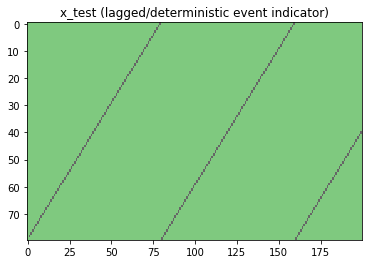

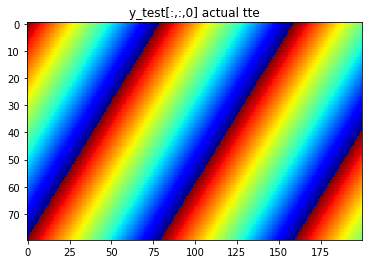

train shape (80000, 200, 1) (80000, 200, 2)


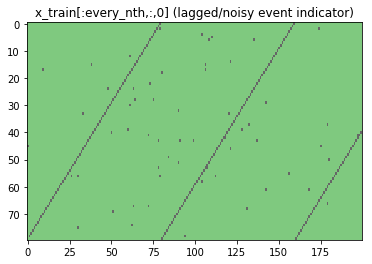

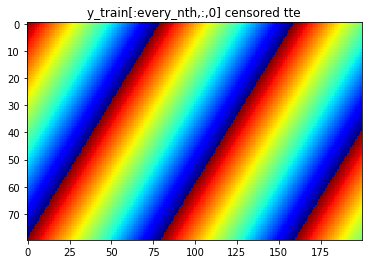

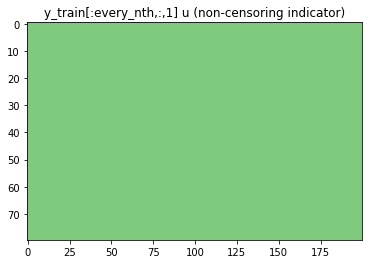

Example TTEs


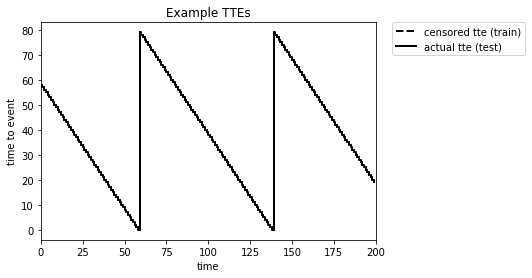

In [11]:
#### Plots
print('test shape',x_test.shape,y_test.shape)
plt.imshow(x_test[:,:,:].sum(axis=2)>0,interpolation="none",cmap='Accent',aspect='auto')
plt.title('x_test (lagged/deterministic event indicator)')
plt.show()
plt.imshow(y_test[:,:,0],interpolation="none",cmap='jet',aspect='auto')
plt.title('y_test[:,:,0] actual tte')
plt.show()

print('train shape',x_train.shape,y_train.shape)
plt.imshow(x_train[:every_nth,:,:].mean(axis=2),interpolation="none",cmap='Accent',aspect='auto')
plt.title('x_train[:every_nth,:,0] (lagged/noisy event indicator)')
plt.show()
plt.imshow(y_train[:every_nth,:,0],interpolation="none",cmap='jet',aspect='auto')
plt.title('y_train[:every_nth,:,0] censored tte')
plt.show()
plt.imshow(y_train[:every_nth,:,1],interpolation="none",cmap='Accent',aspect='auto')
plt.title('y_train[:every_nth,:,1] u (non-censoring indicator)')
plt.show()

## Example TTE:
print('Example TTEs')
plt.plot(y_train[every_nth//4,:,0],label='censored tte (train)',color='black',linestyle='dashed',linewidth=2,drawstyle='steps-post')
plt.plot(y_test[every_nth//4,:,0],label='actual tte (test)',color='black',linestyle='solid',linewidth=2,drawstyle='steps-post')

plt.xlim(0, n_timesteps)
plt.xlabel('time')
plt.ylabel('time to event')
plt.title('Example TTEs')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


# Train a WTTE-RNN
### Things to try out:
    * have fun with data paramaters:
        * every_nth to control event frequency
        * noise_level to make it more noisy
        * n_timesteps 
        * n_features to get more noisy input
    * Generate more interesting temporal relationships
    * Here we use the smallest possible GRU. Try different learning rates, network architectures, initializations. 
    * Try Implementing multivariate distributions, other distributions, data pipelines etc.
    * Invent better output activation layer
    * Invent ways to overcome instability with lots of censoring
    * ETC and have fun!

In [5]:
# Paramaeters for output activation layer initialization.
# Start at naive geometric (beta=1) MLE:
tte_mean_train = np.nanmean(y_train[:,:,0])
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
mean_u = np.nanmean(y_train[:,:,1])
init_alpha = init_alpha/mean_u
print('init_alpha: ',init_alpha,'mean uncensored: ',mean_u)

### Uncomment if you have varying length sequences that is nanpadded to the right:
# mask_value = -1.3371337 # Use some improbable but not nan-causing telltale value
# x_train[:,:,:][np.isnan(x_train)] = mask_value
# y_train[:,:,0][np.isnan(y_train[:,:,0])] = tte_mean_train
# y_train[:,:,1][np.isnan(y_train[:,:,1])] = 0.5
# sample_weights = (x_train[:,:,0]!=mask_value)*1.


init_alpha:  43.4425042957 mean uncensored:  0.8025


In [6]:
history = History()
weightwatcher = WeightWatcher()

# Start building the model
model = Sequential()
# Dont need to specify input_shape=(n_timesteps, n_features) since keras uses dynamic rnn by default
model.add(GRU(1, input_shape=(None, n_features),activation='tanh',return_sequences=True))

model.add(Dense(2))
model.add(Lambda(wtte.output_lambda, 
                 arguments={"init_alpha":init_alpha, 
                            "max_beta_value":4.0}))
loss = wtte.loss(kind='discrete').loss_function

model.compile(loss=loss, optimizer=adam(lr=.01))
# model.compile(loss=loss, optimizer=adam(lr=.01),sample_weight_mode='temporal') # If varying length

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 1)           9         
_________________________________________________________________
dense_1 (Dense)              (None, None, 2)           4         
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 2)           0         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python2.7/site-packages/keras/layers/core.py:633: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, None, 2)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [7]:
# Fit! 
model.fit(x_train, y_train,
          epochs=60, 
          batch_size=x_train.shape[0]//10, 
          verbose=1,
          validation_data=(x_test, y_test),
#           sample_weight = sample_weights # If varying length
          callbacks=[history,weightwatcher])

Train on 80000 samples, validate on 80 samples
Epoch 1/60
80000/80000 [==============================] - 10s - loss: 3.8125 - val_loss: 4.6352
Epoch 2/60
80000/80000 [==============================] - 10s - loss: 3.7743 - val_loss: 4.5895
Epoch 3/60
80000/80000 [==============================] - 10s - loss: 3.7487 - val_loss: 4.5607
Epoch 4/60
80000/80000 [==============================] - 11s - loss: 3.7378 - val_loss: 4.5489
Epoch 5/60
80000/80000 [==============================] - 12s - loss: 3.7353 - val_loss: 4.5443
Epoch 6/60
80000/80000 [==============================] - 11s - loss: 3.7323 - val_loss: 4.5410
Epoch 7/60
80000/80000 [==============================] - 12s - loss: 3.7283 - val_loss: 4.5361
Epoch 8/60
80000/80000 [==============================] - 11s - loss: 3.7228 - val_loss: 4.5261
Epoch 9/60
80000/80000 [==============================] - 12s - loss: 3.7137 - val_loss: 4.5080
Epoch 10/60
80000/80000 [==============================] - 10s - loss: 3.6964 - val_loss:

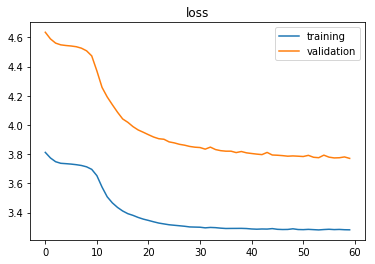

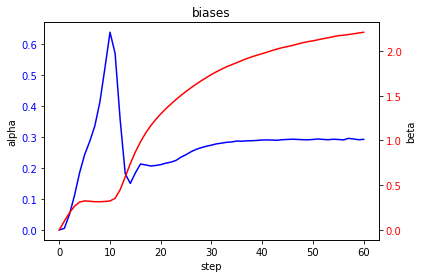

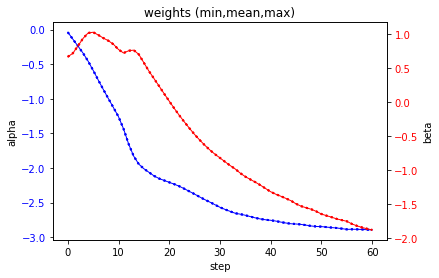

In [8]:
plt.plot(history.history['loss'],    label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.title('loss')
plt.legend()

weightwatcher.plot()

# Predictions
Try out training the model with different levels of noise. With more noise confidence gets lower (smaller beta). With less noise beta goes to maximum value and the predicted mode/peak probability is centered around the actual TTE.

TESTING (no noise in features)
(each horizontal line is a sequence)
(80, 200, 2)


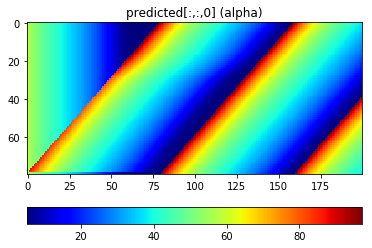

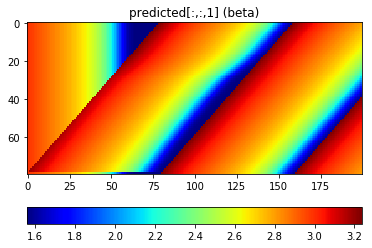

TRAINING (Noisy features)
(80, 200, 2)


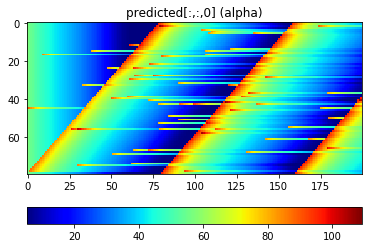

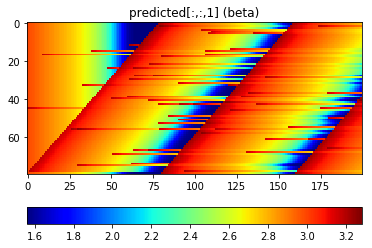

In [9]:
# Make some parametric predictions
print('TESTING (no noise in features)')
print('(each horizontal line is a sequence)')
predicted = model.predict(x_test)
print(predicted.shape)

plt.imshow(predicted[:,:,0],interpolation="none",cmap='jet',aspect='auto')
plt.title('predicted[:,:,0] (alpha)')
plt.colorbar(orientation="horizontal")
plt.show()
plt.imshow(predicted[:,:,1],interpolation="none",cmap='jet',aspect='auto')
plt.title('predicted[:,:,1] (beta)')
plt.colorbar(orientation="horizontal")
plt.show()

print('TRAINING (Noisy features)')
predicted = model.predict(x_train[:every_nth,:,:])
print(predicted.shape)

plt.imshow(predicted[:,:,0],interpolation="none",cmap='jet',aspect='auto')
plt.title('predicted[:,:,0] (alpha)')
plt.colorbar(orientation="horizontal")
plt.show()
plt.imshow(predicted[:,:,1],interpolation="none",cmap='jet',aspect='auto')
plt.title('predicted[:,:,1] (beta)')
plt.colorbar(orientation="horizontal")
plt.show()


one training case:
Cautious (low beta) until first signal then almost thrown off track by noise


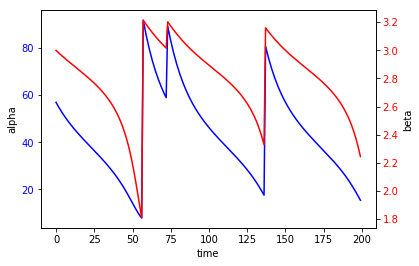

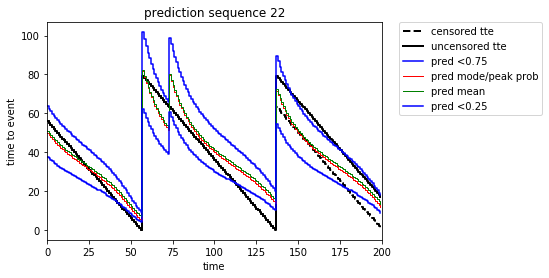

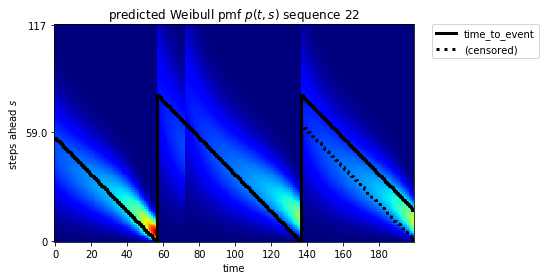

In [10]:
from wtte.plots.weibull_heatmap import weibull_heatmap
# TTE, Event Indicator, Alpha, Beta
drawstyle = 'steps-post'

print('one training case:')
print('Cautious (low beta) until first signal then almost thrown off track by noise')
batch_indx = 2+every_nth//4

# Pick out data for one sequence
this_seq_len = n_timesteps
a = predicted[batch_indx,:this_seq_len,0]
b = predicted[batch_indx,:this_seq_len,1]
t = np.array(xrange(len(a)))
x_this = x_train[batch_indx,:this_seq_len,:]

tte_censored = y_train[batch_indx,:this_seq_len,0]
tte_actual   = y_test[batch_indx,:this_seq_len,0]

u = y_train[batch_indx,:this_seq_len,1]>0
##### Parameters
# Create axes
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(t, a, color='b')
ax1.set_xlabel('time')
ax1.set_ylabel('alpha')

ax2.plot(t, b, color='r')
ax2.set_ylabel('beta')

# Change color of each axis
def color_y_axis(ax, color):
    """Color your axes."""
    for t in ax.get_yticklabels():
        t.set_color(color)
    return None
color_y_axis(ax1, 'b')
color_y_axis(ax2, 'r')
plt.show()

##### Prediction (Using weibull-quantities like quantiles etc)
plt.plot(tte_censored,label='censored tte',color='black',linestyle='dashed',linewidth=2,drawstyle=drawstyle)
plt.plot(t,tte_actual,label='uncensored tte',color='black',linestyle='solid',linewidth=2,drawstyle=drawstyle)

plt.plot(weibull.quantiles(a,b,0.75),color='blue',label='pred <0.75',drawstyle=drawstyle)
plt.plot(weibull.mode(a, b), color='red',linewidth=1,label='pred mode/peak prob',drawstyle=drawstyle)
plt.plot(weibull.mean(a, b), color='green',linewidth=1,label='pred mean',drawstyle='steps-post')
plt.plot(weibull.quantiles(a,b,0.25),color='blue',label='pred <0.25',drawstyle=drawstyle)

plt.xlim(0, this_seq_len)
plt.xlabel('time')
plt.ylabel('time to event')
plt.title('prediction sequence '+str(batch_indx),)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

##### Prediction (Density)
fig, ax = plt.subplots(1)

fig,ax = weibull_heatmap(
    fig,ax,
    t,
    a,
    b,
    max_horizon = int(1.5*tte_actual.max()),
    time_to_event=tte_censored,
    true_time_to_event=tte_actual,
    censoring_indicator = ~u,
    title='predicted Weibull pmf $p(t,s)$ sequence '+str(batch_indx),
    lw=3.0,
    is_discrete=True,
    resolution=None,
    xax_nbins=10,
    yax_nbins=4 
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()